# Data augmentation

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
#export
from exp.nb_09 import *

## PIL transforms

In [ ]:
make_rgb._order=0

In [ ]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_320)
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

In [ ]:
def get_il(tfms): return ImageItemList.from_files(path, tfms=tfms)

In [ ]:
il = get_il(tfms)

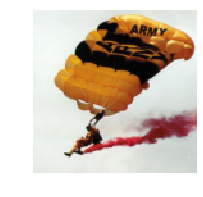

In [ ]:
show_image(il[0])

In [ ]:
img = PIL.Image.open(il.items[0])

### Flip

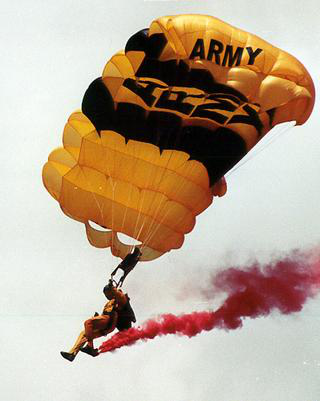

In [ ]:
img

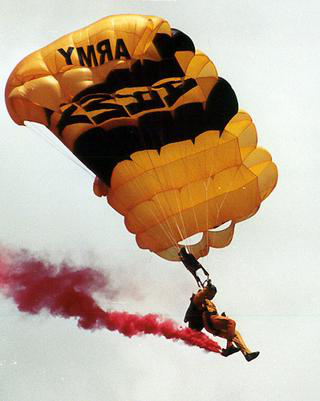

In [ ]:
img.transpose(PIL.Image.FLIP_LEFT_RIGHT)

In [ ]:
#export
from random import random

def show_aug(gen, r=1, c=4, figsize=None):
    if figsize is None: figsize=(c*3,r*3)
    fig,axes = plt.subplots(r,c, figsize=figsize)
    for ax in axes.flat:
        ax.imshow(gen())
        ax.axis('off')

In [ ]:
def pil_random_flip(x): return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random()<0.5 else x

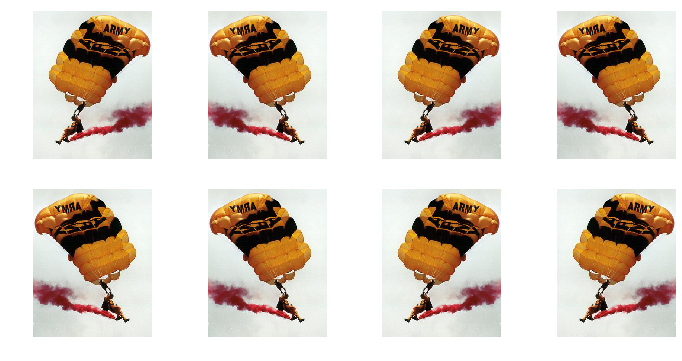

In [ ]:
show_aug(partial(pil_random_flip, img), r=2)

In [ ]:
il1 = get_il(tfms)
il1.items = [il1.items[0]]*8
dl = DataLoader(il1, 8)

In [ ]:
x = next(iter(dl))

In [ ]:
#export
def show_image(im, ax=None, figsize=(3,3)):
    if ax is None: _,ax = plt.subplots(1, 1, figsize=figsize)
    ax.axis('off')
    ax.imshow(im.permute(1,2,0))

def show_batch(x, c=4, figsize=None):
    n = len(x)
    r = int(math.ceil(n/c))
    if figsize is None: figsize=(c*3,r*3)
    fig,axes = plt.subplots(r,c, figsize=figsize)
    for xi,ax in zip(x,axes.flat): show_image(xi, ax)

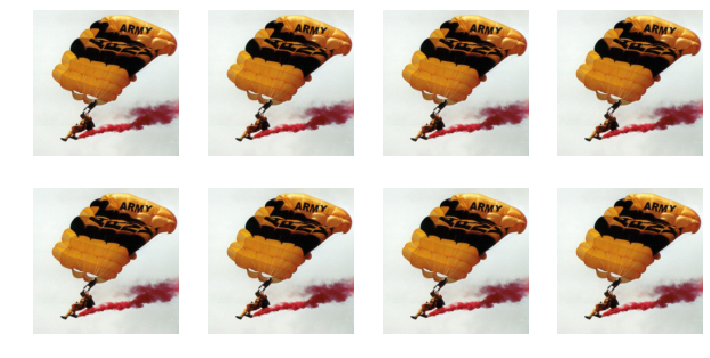

In [ ]:
show_batch(x)

In [ ]:
il1.tfms.append(pil_random_flip)

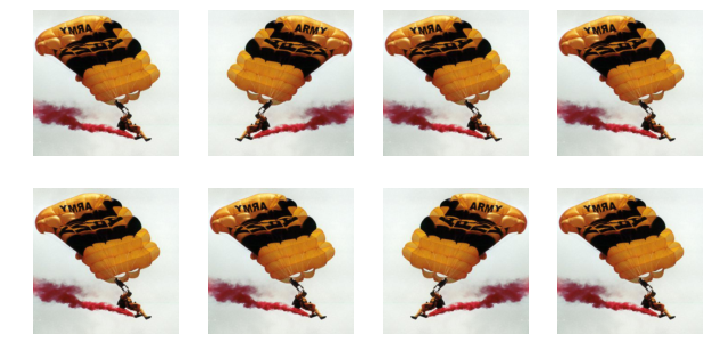

In [ ]:
x = next(iter(dl))
show_batch(x)

In [ ]:
class PilRandomFlip(Transform):
    _order=11
    def __init__(self, p=0.5): self.p=p
    def __call__(self, x):
        return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random()<self.p else x

In [ ]:
#export
class PilTransform(Transform): _order=11

class PilRandomFlip(PilTransform):
    def __init__(self, p=0.5): self.p=p
    def __call__(self, x):
        return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random()<self.p else x

In [ ]:
del(il1.tfms[-1])
il1.tfms.append(PilRandomFlip(0.8))

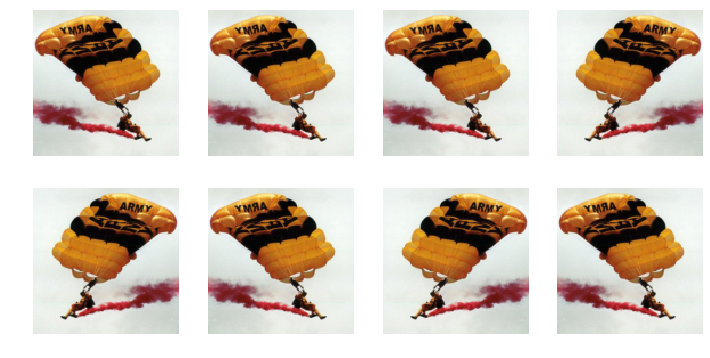

In [ ]:
x = next(iter(dl))
show_batch(x)

### Random crop

In [ ]:
img.size

(320, 401)

Regualr cropping

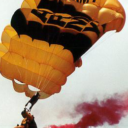

In [ ]:
img.crop((60,60,320,320)).resize((128,128), resample=PIL.Image.BILINEAR)

In [ ]:
cnr2 = (60,60,320,320)
resample = PIL.Image.BILINEAR

In [ ]:
%timeit -n 10 img.crop(cnr2).resize((128,128), resample=resample)

644 µs ± 10.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


More evolved cropping

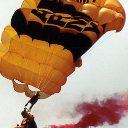

In [ ]:
img.transform((128,128), PIL.Image.EXTENT, cnr2, resample=resample)

In [ ]:
%timeit -n 10 img.transform((128,128), PIL.Image.EXTENT, cnr2, resample=resample)

591 µs ± 12.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
from random import randint

In [ ]:
img.size

(320, 401)

In [ ]:
def process_sz(sz):
    sz = listify(sz)
    return tuple(sz if len(sz)==2 else [sz[0],sz[0]])

In [ ]:
class PilRandomCrop(PilTransform):
    def __init__(self, size, crop_size=None, resample=PIL.Image.BILINEAR): 
        self.resample,self.size = resample,process_sz(size)
        self.crop_size = self.size if crop_size is None else process_sz(crop_size)
        
    def __call__(self, x):
        left,top = randint(0,x.size[0]-self.crop_size[0]),randint(0,x.size[1]-self.crop_size[1])
        corners = (left, top, left+self.crop_size[0], top+self.crop_size[1])
        return x.transform(self.size, PIL.Image.EXTENT, corners, resample=self.resample)

In [ ]:
il1.tfms = [make_rgb, PilRandomCrop(128, 256), to_byte_tensor, to_float_tensor]

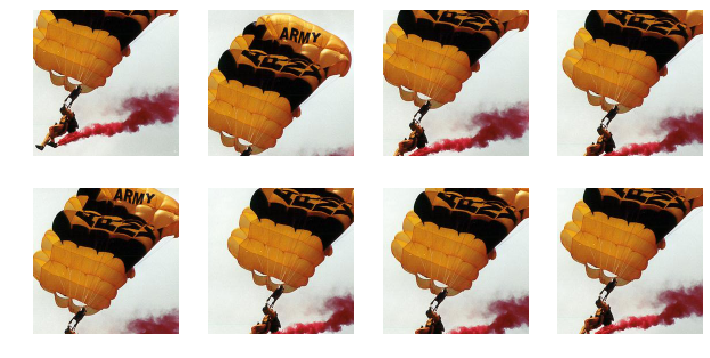

In [ ]:
x = next(iter(dl))
show_batch(x)

If we use `PIL.Image.QUAD`, we can specify any coordinates we want this way, which allows us to do perspective warping.

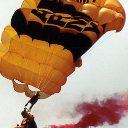

In [ ]:
img.transform((128,128), PIL.Image.QUAD, (60,60,60,320,320,320,320,60), resample=resample)

### Perspective warping

To do perspective warping, we map the corners of the image to new points: for instance, if we want to tilt the image so that the top looks closer to us, the top/left corner needs to be shifted to the right and the top/right to the left. To avoid squishing, the bottom/left corner needs to be shifted to the left and the bottom/right corner to the right. For instance if we have an image with corners in:
```
(60,60,60,280,280,280,280,60)
```
(top/left, bottom/left, bottom/right, top/right) then a warped version is
```
(90,60,30,280,310,280,250,60)
```

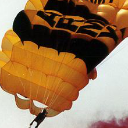

In [ ]:
img.transform((128,128), PIL.Image.QUAD, (60,60,60,280,280,280,280,60), resample=resample)

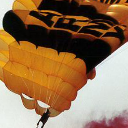

In [ ]:
img.transform((128,128), PIL.Image.QUAD, (90,60,30,280,310,280,250,60), resample=resample)

If, we want to tilt so that the top looks more behind, we just need to shift in the other direction:

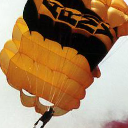

In [ ]:
img.transform((128,128), PIL.Image.QUAD, (30,90,60,280,250,280,310,60), resample=resample)

In [ ]:
def uniform(a,b): return a + (b-a) * random()

In [ ]:
class PilTiltRandomCrop(PilTransform):
    def __init__(self, size, crop_size=None, magnitude=0., resample=PIL.Image.BILINEAR): 
        self.resample,self.size,self.magnitude = resample,process_sz(size),magnitude
        self.crop_size = self.size if crop_size is None else process_sz(crop_size)
        
    def __call__(self, x):
        up_t,lr_t = uniform(-self.magnitude, self.magnitude),uniform(-self.magnitude, self.magnitude)
        left,top = randint(0,x.size[0]-self.crop_size[0]),randint(0,x.size[1]-self.crop_size[1])
        tgt_corners = tensor([[-up_t, -lr_t], [up_t, 1+lr_t], [1-up_t, 1+lr_t], [1+up_t, -lr_t]])
        tgt_corners = tgt_corners * tensor(self.crop_size).float() + tensor([left,top]).float()
        tgt_corners = tuple([int(o.item()) for o in tgt_corners.view(-1)])
        return x.transform(self.size, PIL.Image.QUAD, tgt_corners, resample=self.resample)

In [ ]:
il1.tfms = [make_rgb, PilTiltRandomCrop(128, 256, magnitude=0.3), to_byte_tensor, to_float_tensor]

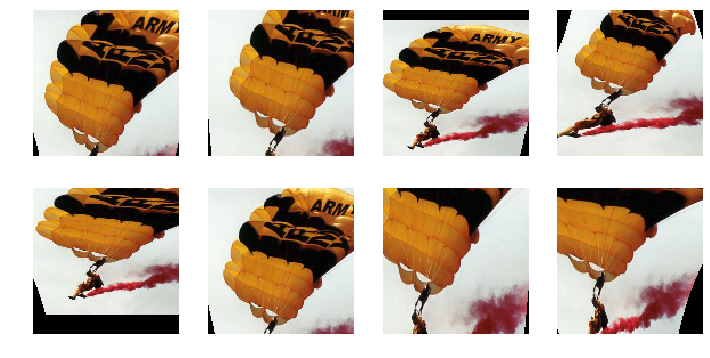

In [ ]:
x = next(iter(dl))
show_batch(x)

Problem is that black padding appears as soon as our target points are outside of the image, so we have to limit the magnitude if we want to avoid that.

In [ ]:
class PilTiltRandomCrop(PilTransform):
    def __init__(self, size, crop_size=None, magnitude=0., resample=PIL.Image.BILINEAR): 
        self.resample,self.size,self.magnitude = resample,process_sz(size),magnitude
        self.crop_size = self.size if crop_size is None else process_sz(crop_size)
        
    def __call__(self, x):
        left,top = randint(0,x.size[0]-self.crop_size[0]),randint(0,x.size[1]-self.crop_size[1])
        top_magn = min(self.magnitude, left/self.crop_size[0], (x.size[0]-left)/self.crop_size[0]-1)
        lr_magn  = min(self.magnitude, top /self.crop_size[1], (x.size[1]-top) /self.crop_size[1]-1)
        up_t,lr_t = uniform(-top_magn, top_magn),uniform(-lr_magn, lr_magn)
        tgt_corners = tensor([[-up_t, -lr_t], [up_t, 1+lr_t], [1-up_t, 1+lr_t], [1+up_t, -lr_t]])
        tgt_corners = tgt_corners * tensor(self.crop_size).float() + tensor([left,top]).float()
        tgt_corners = tuple([int(o.item()) for o in tgt_corners.view(-1)])
        return x.transform(self.size, PIL.Image.QUAD, tgt_corners, resample=self.resample)

In [ ]:
il1.tfms = [make_rgb, PilTiltRandomCrop(128, 256, magnitude=0.3), to_byte_tensor, to_float_tensor]

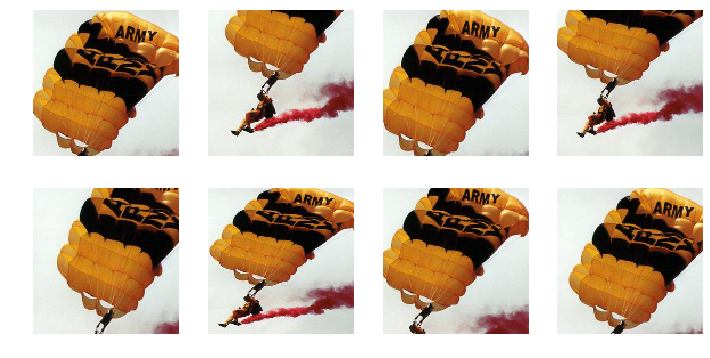

In [ ]:
x = next(iter(dl))
show_batch(x)

## Single tensor transforms

In [ ]:
[(o._order,o) for o in sorted(tfms, key=operator.attrgetter('_order'))]

[(0, <function exp.nb_08.make_rgb(item)>),
 (10, <exp.nb_08.ResizeFixed at 0x7f798fd5a7b8>),
 (11, <__main__.PilRandomFlip at 0x7f791d23a7b8>),
 (20, <function exp.nb_08.to_byte_tensor(item)>),
 (30, <function exp.nb_08.to_float_tensor(item)>)]

### Model

In [ ]:
nfs = [32,64,128,256,512]

In [ ]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [ ]:
data = DataBunch(train_dl, valid_dl, 3, 10)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [ ]:
run.fit(1, learn)

train: [1.7537384151543354, tensor(0.3995, device='cuda:0')]
valid: [1.71223388671875, tensor(0.4380, device='cuda:0')]


## Export

In [ ]:
!./notebook2script.py 09_optimizers.ipynb

Converted 09_optimizers.ipynb to nb_09.py
